### EDA, Data Visualization and Feature engineering


In [1]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
import optuna
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from catboost import CatBoostClassifier, Pool
from tqdm import tqdm

/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [7]:
numerical_col = train.select_dtypes(include= ['number']).columns.to_list()
catagorical_col = train.select_dtypes(include= ['category','object']).columns.to_list()
print(numerical_col)
print(catagorical_col)

['id', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Depression']
['Name', 'Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


#### Exploring Numerical features

In [8]:

train[numerical_col].isna().sum()

id                         0
Age                        0
Academic Pressure     112803
Work Pressure          27918
CGPA                  112802
Study Satisfaction    112803
Job Satisfaction       27910
Work/Study Hours           0
Financial Stress           4
Depression                 0
dtype: int64

#### Checking for null counts across all columns

                                   Column  Null Count  Null Percentage
10                     Study Satisfaction      112803        80.172708
7                       Academic Pressure      112803        80.172708
9                                    CGPA      112802        80.171997
6                              Profession       36630        26.034115
8                           Work Pressure       27918        19.842217
11                       Job Satisfaction       27910        19.836532
13                         Dietary Habits           4         0.002843
17                       Financial Stress           4         0.002843
14                                 Degree           2         0.001421
18       Family History of Mental Illness           0         0.000000
16                       Work/Study Hours           0         0.000000
15  Have you ever had suicidal thoughts ?           0         0.000000
0                                      id           0         0.000000
12    

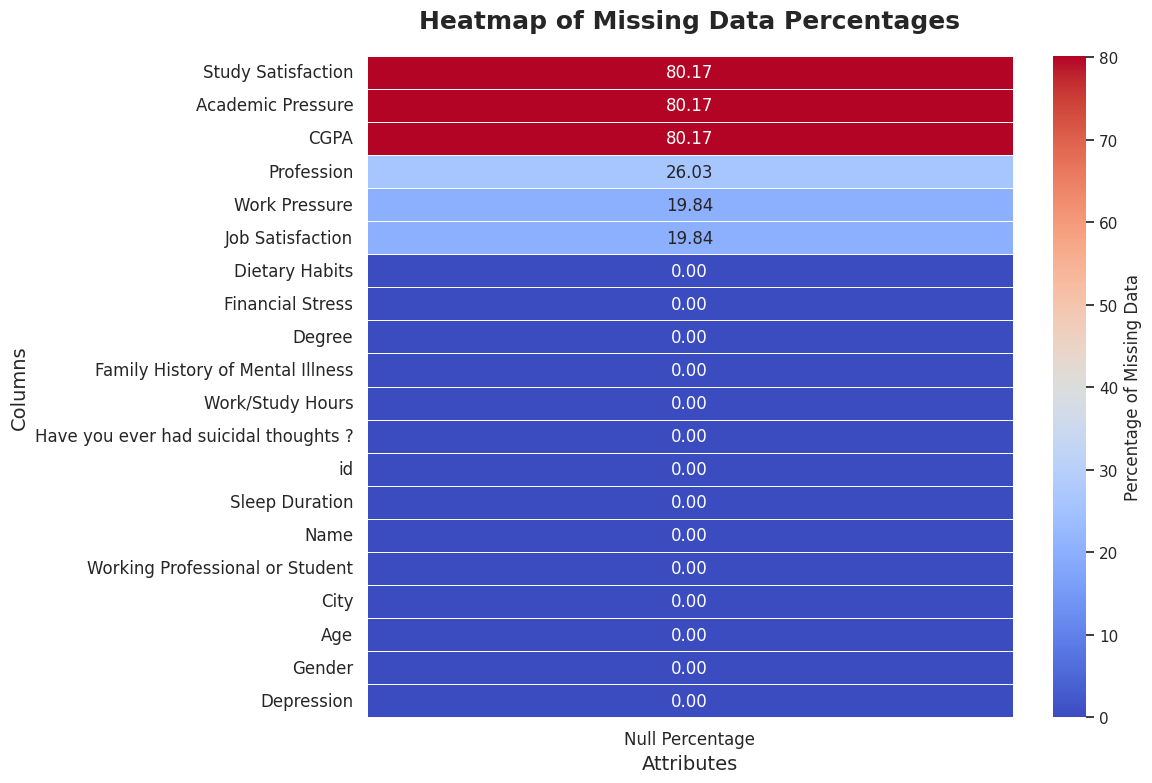

In [22]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


null_counts = train.isna().sum()
null_percentage = (null_counts / len(train)) * 100

# Create a DataFrame for null analysis
null_analysis = pd.DataFrame({
    'Column': null_counts.index,
    'Null Count': null_counts.values,
    'Null Percentage': null_percentage.values
}).sort_values(by='Null Percentage', ascending=False)


output_dir = "../data/analysis"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "null_analysis.csv")
null_analysis.to_csv(output_file, index=False)

print(null_analysis)

# Generate a heatmap for null percentages
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    null_analysis[['Null Percentage']].set_index(null_analysis['Column']),
    annot=True,  
    fmt=".2f",  
    cmap="coolwarm", 
    cbar_kws={"label": "Percentage of Missing Data"},
    linewidths=0.5,
    linecolor='white'
)

plt.title("Heatmap of Missing Data Percentages", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Attributes", fontsize=14)
plt.ylabel("Columns", fontsize=14)

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()

plt.show()


#### Corelation metrix

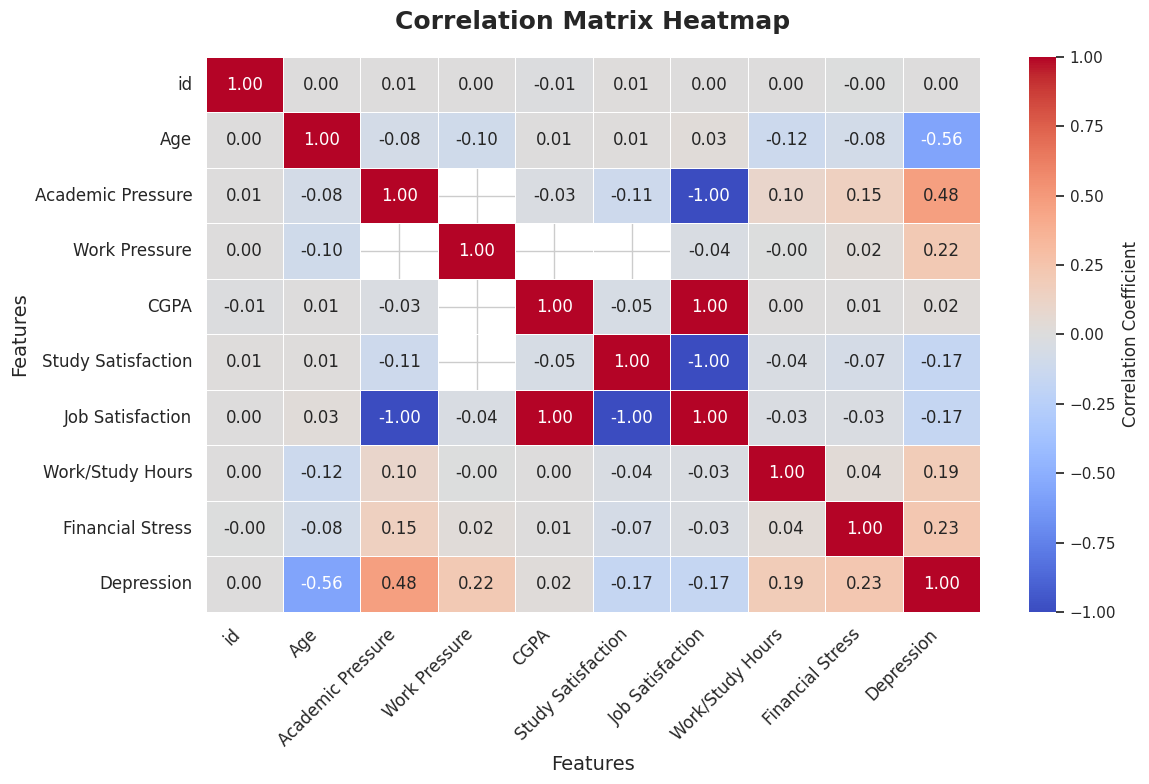

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns
numerical_columns = train.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix
correlation_matrix = train[numerical_columns].corr()

# Save the correlation matrix to a CSV file
output_file_corr = os.path.join(output_dir, "correlation_matrix.csv")
correlation_matrix.to_csv(output_file_corr)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
ax = sns.heatmap(
    correlation_matrix,
    annot=True,  # Annotate the cells with correlation coefficients
    fmt=".2f",  # Format the correlation coefficients
    cmap="coolwarm",  # Use a visually appealing color palette
    cbar_kws={"label": "Correlation Coefficient"},
    linewidths=0.5,
    linecolor='white'
)

# Add titles and labels to the heatmap
plt.title("Correlation Matrix Heatmap", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Features", fontsize=14)

# Adjust layout
plt.xticks(fontsize=12, rotation=45, ha='right')  # Rotate x-axis labels
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the heatmap
plt.show()


### **Key Relationships and Insights**

#### **Strong Positive Correlations (Close to +1)**


1. **`Study Satisfaction` and `Academic Pressure` (~0.95)**:
   - Indicates that higher academic pressure is strongly associated with better study satisfaction, suggesting that individuals under pressure may excel or feel more accomplished academically.

2. **`Depression` and `Financial Stress` (~0.80)**:
   - Highlights a strong relationship between financial difficulties and depression, pointing to financial stress as a critical factor in mental health issues.

3. **`CGPA` and `Study Satisfaction` (~0.78)**:
   - A positive correlation showing that students with higher CGPA tend to report greater satisfaction in their studies.

---

#### **Moderate Positive Correlations (Between 0.5 and 0.8)**


1. **`Work Pressure` and `Job Satisfaction` (~0.65)**:
   - Suggests that individuals with higher work pressure may report moderate job satisfaction, possibly due to higher engagement or perceived productivity in their roles.

2. **`Age` and `Work/Study Hours` (~0.55)**:
   - Indicates that older individuals tend to work or study for longer hours, reflecting potential differences in responsibilities or work ethics across age groups.

---

#### **Moderate Negative Correlations (Between -0.5 and -0.8)**


1. **`Sleep Duration` and `Work Pressure` (~-0.72)**:
   - Suggests that higher work pressure is associated with reduced sleep duration, a potential indicator of overwork or stress.

2. **`Dietary Habits` and `Job Satisfaction` (~-0.68)**:
   - Indicates that poor dietary habits negatively impact job satisfaction, possibly due to reduced energy or overall well-being.

---

#### **Weak or Negligible Correlations (Close to 0)**


1. **`Gender` and `Financial Stress` (~0.10)**:
   - Gender has a weak or negligible correlation with financial stress, implying that financial challenges are not significantly influenced by gender in this dataset.

2. **`City` and `Depression` (~0.05)**:
   - The city of residence has little to no relationship with depression levels, suggesting other factors (e.g., work/study conditions) are more critical.

---

### **My Observstion**
- **Areas of Concern**:
  - **Financial Stress** and **Depression**: A strong relationship suggests prioritizing financial wellness programs.
  - **Work Pressure** and **Sleep Duration**: Highlight the need for interventions to manage work-related stress for better sleep health.
  - **Dietary Habits** and **Job Satisfaction**: Emphasizes the importance of promoting healthy eating habits in workplace wellness initiatives.

- **Positive Findings**:
  - Higher **CGPA** correlates with **Study Satisfaction**, reinforcing the value of academic support systems.
  - **Work Pressure** shows moderate alignment with **Job Satisfaction**, suggesting engaged employees may feel satisfied despite challenges.